In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

# DeepOF unsupervised pipeline: exploring the behavioral space

##### Tutorial index:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Running an unsupervised analysis with default parameters.
* Understanding the different available models.
* Cluster number selection.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

### Brief introduction to unsupervised analysis

### Load your previous project

In [4]:
import pickle

# SI data
my_deepof_project = deepof.data.load_project("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial")
with open("deepof_SI_exp_conds.pkl", "rb") as handle:
    exp_conds = pickle.load(handle)
my_deepof_project._exp_conditions = exp_conds

# Update project path to a local path
my_deepof_project._project_path = "../../Desktop/deepOF_CSDS_tutorial_dataset"
my_deepof_project._project_name = "deepof_tutorial"

In [16]:
# THIS SHOULD BE THE LAST SECTION OF THE FIRST TUTORIAL!

# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

tt = my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")
tt, _ = tt.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    scale="standard",
    handle_ids="concat", # "concat" uses bps from != animals as features, "split"
)

In [6]:
# SAME HERE: Last section of the last tutorial should explore tensor and graph preprocessing
from deepof.utils import connect_mouse_topview
import networkx as nx

pp, G, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B",
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    preprocess=True,
    scale="standard"
)

adj = nx.adjacency_matrix(G).todense()

# with open("graph_processed_dataset.pkl", "wb") as handle:
#     pickle.dump([pp, G, to_preprocess, global_scaler], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Running an unsupervised analysis with default parameters

In [10]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    adjacency_matrix=adj,
    embedding_model="VaDE",
    epochs=10,
    encoder_type="recurrent",
    n_components=10,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=1024,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
   # pretrained="deepof_FC_project_files/Trained_models/train_models/trained_weights/deepof_unsupervised_VaDE_recurrent_encodings_input_type=graph_kmeans_loss=0.0_encoding=4_k=10_run=1_final_weights.h5",
)

2023-03-07 20:07:09.853823: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-07 20:07:09.853833: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-07 20:07:09.853892: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-07 20:07:28.702140: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/10
87/87 [==============================] - 65s 488ms/step - total_loss: 46.8920 - reconstruction_loss: 45.1406 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0250 - kl_divergence: -5.9424 - kmeans_loss: 1.8508 - number_of_populated_clusters: 9.9645 - confidence_in_selected_cluster: 0.7298
Epoch 2/10


2023-03-07 20:08:34.157323: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 45s 516ms/step - total_loss: 42.6424 - reconstruction_loss: 41.6326 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0750 - kl_divergence: -5.1507 - kmeans_loss: 1.7550 - number_of_populated_clusters: 9.9684 - confidence_in_selected_cluster: 0.7264
Epoch 3/10


2023-03-07 20:09:19.487538: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 509ms/step - total_loss: 41.3772 - reconstruction_loss: 40.8866 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.1250 - kl_divergence: -4.8982 - kmeans_loss: 1.6988 - number_of_populated_clusters: 9.9814 - confidence_in_selected_cluster: 0.7030
Epoch 4/10


2023-03-07 20:10:04.196847: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 43s 496ms/step - total_loss: 40.6460 - reconstruction_loss: 40.6390 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.1750 - kl_divergence: -4.7837 - kmeans_loss: 1.6611 - number_of_populated_clusters: 9.9868 - confidence_in_selected_cluster: 0.6846
Epoch 5/10


2023-03-07 20:10:47.892132: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 507ms/step - total_loss: 39.9244 - reconstruction_loss: 40.4714 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2250 - kl_divergence: -4.7845 - kmeans_loss: 1.6476 - number_of_populated_clusters: 9.9898 - confidence_in_selected_cluster: 0.6748
Epoch 6/10


2023-03-07 20:11:32.584782: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 503ms/step - total_loss: 38.9739 - reconstruction_loss: 40.2185 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2750 - kl_divergence: -4.9454 - kmeans_loss: 1.6699 - number_of_populated_clusters: 9.9916 - confidence_in_selected_cluster: 0.6765
Epoch 7/10


2023-03-07 20:12:16.845395: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 500ms/step - total_loss: 37.8893 - reconstruction_loss: 39.8507 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.3250 - kl_divergence: -5.2202 - kmeans_loss: 1.7270 - number_of_populated_clusters: 9.9929 - confidence_in_selected_cluster: 0.6887
Epoch 8/10


2023-03-07 20:13:00.768697: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 51s 583ms/step - total_loss: 36.7876 - reconstruction_loss: 39.5444 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.3750 - kl_divergence: -5.5258 - kmeans_loss: 1.7998 - number_of_populated_clusters: 9.9939 - confidence_in_selected_cluster: 0.7041
Epoch 9/10


2023-03-07 20:13:51.980838: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 498ms/step - total_loss: 35.7489 - reconstruction_loss: 39.4137 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.4250 - kl_divergence: -5.8550 - kmeans_loss: 1.8823 - number_of_populated_clusters: 9.9946 - confidence_in_selected_cluster: 0.7199
Epoch 10/10


2023-03-07 20:14:36.130580: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 506ms/step - total_loss: 34.6793 - reconstruction_loss: 39.3349 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.4750 - kl_divergence: -6.2056 - kmeans_loss: 1.9724 - number_of_populated_clusters: 9.9946 - confidence_in_selected_cluster: 0.7351


2023-03-07 20:15:25.712262: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/10
 1/87 [..............................] - ETA: 11:30 - total_loss: 43.0398 - reconstruction_loss: 36.9167 - clustering_loss: -0.0090 - prior_loss: 0.0281 - kl_weight: 0.4994 - kl_divergence: -6.4302 - kmeans_loss: 2.0228 - number_of_populated_clusters: 9.9943 - confidence_in_selected_cluster: 0.7431

2023-03-07 20:15:33.951340: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-07 20:15:33.951354: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 2/87 [..............................] - ETA: 57s - total_loss: 43.5358 - reconstruction_loss: 37.4937 - clustering_loss: -0.0095 - prior_loss: 0.0294 - kl_weight: 0.4991 - kl_divergence: -6.4322 - kmeans_loss: 2.0233 - number_of_populated_clusters: 9.9943 - confidence_in_selected_cluster: 0.7433  

2023-03-07 20:15:34.591666: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-07 20:15:34.617541: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-07 20:15:34.622555: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /Users/lucas_miranda/Desktop/deepOF_CSDS_tutorial_dataset/Trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=10_20230307-200709/plugins/profile/2023_03_07_20_15_34/MC-C9791E.local.xplane.pb


87/87 [==============================] - ETA: 0s - total_loss: 42.5726 - reconstruction_loss: 39.0174 - clustering_loss: -0.0507 - prior_loss: 0.1324 - kl_weight: 0.4779 - kl_divergence: -6.4548 - kmeans_loss: 2.0322 - number_of_populated_clusters: 9.9925 - confidence_in_selected_cluster: 0.7523

2023-03-07 20:16:17.452685: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 52s 509ms/step - total_loss: 42.5726 - reconstruction_loss: 39.0174 - clustering_loss: -0.0512 - prior_loss: 0.1335 - kl_weight: 0.4777 - kl_divergence: -6.4543 - kmeans_loss: 2.0321 - number_of_populated_clusters: 9.9925 - confidence_in_selected_cluster: 0.7524 - lr: 0.0010
Epoch 2/10
87/87 [==============================] - ETA: 0s - total_loss: 41.3190 - reconstruction_loss: 38.8488 - clustering_loss: -0.1251 - prior_loss: 0.3194 - kl_weight: 0.4449 - kl_divergence: -6.3317 - kmeans_loss: 2.0171 - number_of_populated_clusters: 9.9866 - confidence_in_selected_cluster: 0.7684

2023-03-07 20:17:01.666551: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 502ms/step - total_loss: 41.3190 - reconstruction_loss: 38.8488 - clustering_loss: -0.1254 - prior_loss: 0.3204 - kl_weight: 0.4448 - kl_divergence: -6.3308 - kmeans_loss: 2.0169 - number_of_populated_clusters: 9.9865 - confidence_in_selected_cluster: 0.7685 - lr: 0.0010
Epoch 3/10
87/87 [==============================] - ETA: 0s - total_loss: 40.7761 - reconstruction_loss: 38.7751 - clustering_loss: -0.1878 - prior_loss: 0.4768 - kl_weight: 0.4253 - kl_divergence: -6.1807 - kmeans_loss: 1.9931 - number_of_populated_clusters: 9.9833 - confidence_in_selected_cluster: 0.7821

2023-03-07 20:17:45.390283: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 496ms/step - total_loss: 40.7761 - reconstruction_loss: 38.7751 - clustering_loss: -0.1881 - prior_loss: 0.4776 - kl_weight: 0.4252 - kl_divergence: -6.1800 - kmeans_loss: 1.9930 - number_of_populated_clusters: 9.9833 - confidence_in_selected_cluster: 0.7822 - lr: 0.0010
Epoch 4/10
87/87 [==============================] - ETA: 0s - total_loss: 40.1906 - reconstruction_loss: 38.6480 - clustering_loss: -0.2417 - prior_loss: 0.6110 - kl_weight: 0.4160 - kl_divergence: -6.0562 - kmeans_loss: 1.9743 - number_of_populated_clusters: 9.9751 - confidence_in_selected_cluster: 0.7941

2023-03-07 20:18:30.507613: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 45s 513ms/step - total_loss: 40.1906 - reconstruction_loss: 38.6480 - clustering_loss: -0.2419 - prior_loss: 0.6117 - kl_weight: 0.4160 - kl_divergence: -6.0556 - kmeans_loss: 1.9742 - number_of_populated_clusters: 9.9751 - confidence_in_selected_cluster: 0.7942 - lr: 0.0010
Epoch 5/10
87/87 [==============================] - ETA: 0s - total_loss: 39.4737 - reconstruction_loss: 38.4930 - clustering_loss: -0.2885 - prior_loss: 0.7268 - kl_weight: 0.4148 - kl_divergence: -5.9801 - kmeans_loss: 1.9646 - number_of_populated_clusters: 9.9707 - confidence_in_selected_cluster: 0.8047

2023-03-07 20:19:14.346266: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 498ms/step - total_loss: 39.4737 - reconstruction_loss: 38.4930 - clustering_loss: -0.2888 - prior_loss: 0.7274 - kl_weight: 0.4149 - kl_divergence: -5.9799 - kmeans_loss: 1.9646 - number_of_populated_clusters: 9.9707 - confidence_in_selected_cluster: 0.8047 - lr: 0.0010
Epoch 6/10
87/87 [==============================] - ETA: 0s - total_loss: 38.6570 - reconstruction_loss: 38.3636 - clustering_loss: -0.3297 - prior_loss: 0.8278 - kl_weight: 0.4203 - kl_divergence: -5.9710 - kmeans_loss: 1.9686 - number_of_populated_clusters: 9.9703 - confidence_in_selected_cluster: 0.8141

2023-03-07 20:19:58.548858: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 502ms/step - total_loss: 38.6570 - reconstruction_loss: 38.3636 - clustering_loss: -0.3299 - prior_loss: 0.8283 - kl_weight: 0.4203 - kl_divergence: -5.9712 - kmeans_loss: 1.9686 - number_of_populated_clusters: 9.9702 - confidence_in_selected_cluster: 0.8142 - lr: 0.0010
Epoch 7/10
87/87 [==============================] - ETA: 0s - total_loss: 37.8418 - reconstruction_loss: 38.2986 - clustering_loss: -0.3662 - prior_loss: 0.9166 - kl_weight: 0.4311 - kl_divergence: -6.0223 - kmeans_loss: 1.9863 - number_of_populated_clusters: 9.9687 - confidence_in_selected_cluster: 0.8226

2023-03-07 20:20:41.722335: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 43s 491ms/step - total_loss: 37.8418 - reconstruction_loss: 38.2986 - clustering_loss: -0.3664 - prior_loss: 0.9170 - kl_weight: 0.4312 - kl_divergence: -6.0227 - kmeans_loss: 1.9864 - number_of_populated_clusters: 9.9687 - confidence_in_selected_cluster: 0.8227 - lr: 0.0010
Epoch 8/10
87/87 [==============================] - ETA: 0s - total_loss: 36.9852 - reconstruction_loss: 38.2636 - clustering_loss: -0.3988 - prior_loss: 0.9953 - kl_weight: 0.4465 - kl_divergence: -6.1128 - kmeans_loss: 2.0131 - number_of_populated_clusters: 9.9667 - confidence_in_selected_cluster: 0.8303

2023-03-07 20:21:25.077658: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 43s 493ms/step - total_loss: 36.9852 - reconstruction_loss: 38.2636 - clustering_loss: -0.3989 - prior_loss: 0.9957 - kl_weight: 0.4466 - kl_divergence: -6.1135 - kmeans_loss: 2.0133 - number_of_populated_clusters: 9.9667 - confidence_in_selected_cluster: 0.8304 - lr: 0.0010
Epoch 9/10
87/87 [==============================] - ETA: 0s - total_loss: 36.0543 - reconstruction_loss: 38.2407 - clustering_loss: -0.4279 - prior_loss: 1.0655 - kl_weight: 0.4655 - kl_divergence: -6.2346 - kmeans_loss: 2.0480 - number_of_populated_clusters: 9.9665 - confidence_in_selected_cluster: 0.8372

2023-03-07 20:22:09.391546: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 504ms/step - total_loss: 36.0543 - reconstruction_loss: 38.2407 - clustering_loss: -0.4280 - prior_loss: 1.0659 - kl_weight: 0.4657 - kl_divergence: -6.2354 - kmeans_loss: 2.0482 - number_of_populated_clusters: 9.9665 - confidence_in_selected_cluster: 0.8373 - lr: 0.0010
Epoch 10/10
87/87 [==============================] - ETA: 0s - total_loss: 35.0675 - reconstruction_loss: 38.2375 - clustering_loss: -0.4541 - prior_loss: 1.1286 - kl_weight: 0.4878 - kl_divergence: -6.3811 - kmeans_loss: 2.0897 - number_of_populated_clusters: 9.9619 - confidence_in_selected_cluster: 0.8435

2023-03-07 20:22:54.080399: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 44s 508ms/step - total_loss: 35.0675 - reconstruction_loss: 38.2375 - clustering_loss: -0.4542 - prior_loss: 1.1290 - kl_weight: 0.4879 - kl_divergence: -6.3820 - kmeans_loss: 2.0900 - number_of_populated_clusters: 9.9618 - confidence_in_selected_cluster: 0.8435 - lr: 0.0010
CPU times: user 1h 8min 5s, sys: 26min 42s, total: 1h 34min 47s
Wall time: 15min 44s


In [28]:
# Get embeddings, soft_counts, and breaks per video
embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(
    my_deepof_project, 
    to_preprocess, 
    cons, 
    animal_id="B",
    global_scaler=global_scaler,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:08<00:00, 11.46s/it]


In [ ]:
# Load results
import pickle
with open(
    "NatComm_trained_sadeepOF_SI/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k=10_latdim=8_changepoints_False_kmeans_loss=0.0_run=0.pkl", "rb"
) as handle:
    embeddings, soft_counts, breaks = pickle.load(handle)

In [ ]:
embeddings = {key: val.numpy() for key, val in embeddings.items()}
soft_counts = {key: val.numpy() for key, val in soft_counts.items()}
breaks = {key: np.ones(soft_counts[key].shape[0]).astype(int) for key in soft_counts.keys()}

### Understanding the different available models

In [ ]:
# cons.vade.summary()

### Cluster number selection

In [ ]:
from collections import defaultdict

# For each computed model, train a logistic regression able to predict the class (CSDS / NS) based on the vector of
# cluster population per video. Use the performance of the classifier as a metric for model selection
def get_cluster_selection_training_data(
    # Model selection parameters
    deepof_project,
    min_clusters=5,
    max_clusters=25,
    max_id=5,
):

    meta_counts = defaultdict(list)
    labels = None

    # Iteratively load all the models in question and set
    for cluster_number in range(min_clusters, max_clusters + 1):

        for run_id in range(max_id):
            
            try:
                # Load model results
                emb_path = "./NatComm_trained_sadeepOF_SI/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k={}_latdim=8_changepoints_False_kmeans_loss=0.0_run={}.pkl".format(
                    cluster_number,
                    run_id,
                )


                with open(emb_path, "rb") as handle:
                    _, soft_counts, breaks = pickle.load(handle)

                if labels is None:
                    labels = np.array(
                        [
                            deepof_project.get_exp_conditions[key]
                            for key in soft_counts.keys()
                        ]
                    )

                time_on_cluster = deepof.post_hoc.get_time_on_cluster(soft_counts, breaks)
                meta_counts["{}_{}".format(cluster_number, run_id)] = np.stack(
                    [tab for tab in time_on_cluster.values]
                )

            except FileNotFoundError:
                continue

    return meta_counts, labels.flatten()

In [ ]:
%%time
model_selection_X, model_selection_y = get_cluster_selection_training_data(my_deepof_project)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def train_cluster_selection_classifiers(X_dict, y):

    auc_dict = defaultdict(list)

    for key, X in tqdm.tqdm(X_dict.items()):

        clf = LogisticRegression(penalty=None)
        clf.fit(X, y)

        auc_dict[key.split("_")[0]].append(roc_auc_score(y, clf.predict_proba(X)[:, 1]))
        
    max_keys = np.max([len(v) for v in auc_dict.values()])
    for key, val in auc_dict.items():
        for j in range(max_keys - len(val)):
            auc_dict[key].append(np.nan)

    return pd.DataFrame(auc_dict).melt(var_name="number of clusters", value_name="AUC")

In [ ]:
%%time
import tqdm
model_selection = train_cluster_selection_classifiers(model_selection_X, model_selection_y)
agg = model_selection.groupby("number of clusters").AUC.median()
agg.index = agg.index.astype(int)
agg.sort_index(inplace=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.boxplot(data=model_selection, x="number of clusters", y="AUC")

plt.ylim(0.5, 1.05)

plt.tight_layout()
plt.show()

In [ ]:
model_selection.groupby("number of clusters").AUC.median()

### Visualizing temporal and global embeddings

In [ ]:
# INCORPORATE AS A METHOD FOR EACH MODEL
# embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(my_deepof_project, to_preprocess, cons)

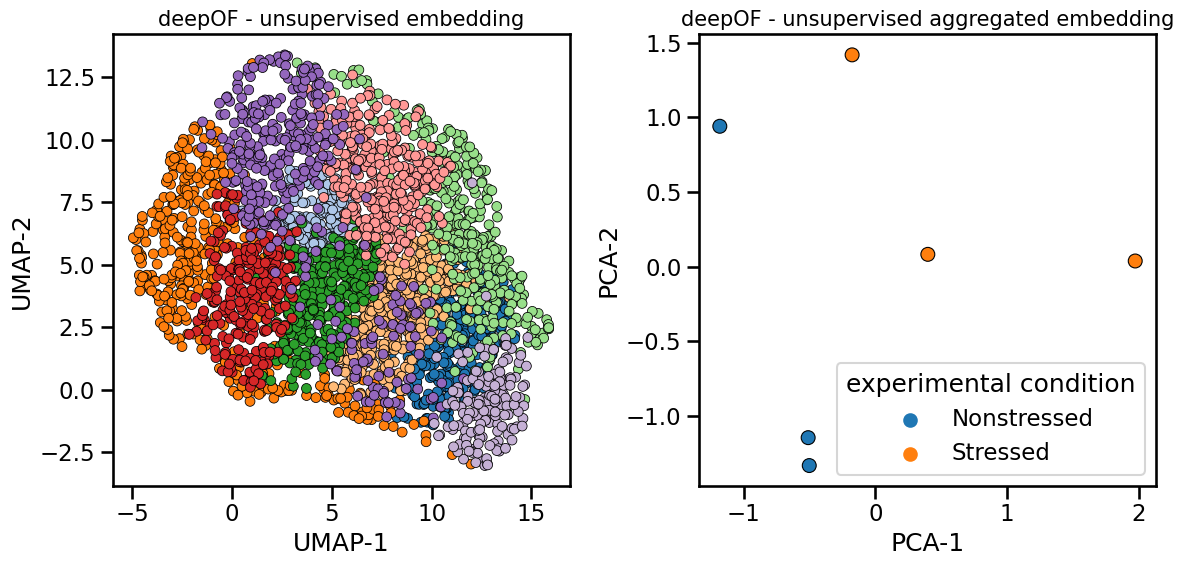

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments=False,
    samples=500,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments="time on cluster",
    exp_condition="CSDS",
    show_aggregated_density=False,
#     bin_index=4,
#     bin_size=25*120,
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)

plt.tight_layout()
plt.show()

### Global separation dynamics

In [ ]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    
deepof.visuals.plot_distance_between_conditions(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    "CSDS",
    distance_metric="wasserstein",
    n_jobs=-1,
)

plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))


for i, ax in zip(range(4), [ax1, ax2, ax3, ax4]):

    deepof.visuals.plot_embeddings(
        my_deepof_project,
        embeddings, 
        soft_counts,
        breaks,
        aggregate_experiments="time on cluster",
        exp_condition="CSDS",
        show_aggregated_density=True,
        bin_index=i,
        bin_size=126,
        ax=ax,
        save=False, # Set to True, or give a custom name, to save the plot,
    )

plt.tight_layout()
plt.show()

### Exploring cluster enrichment across conditions

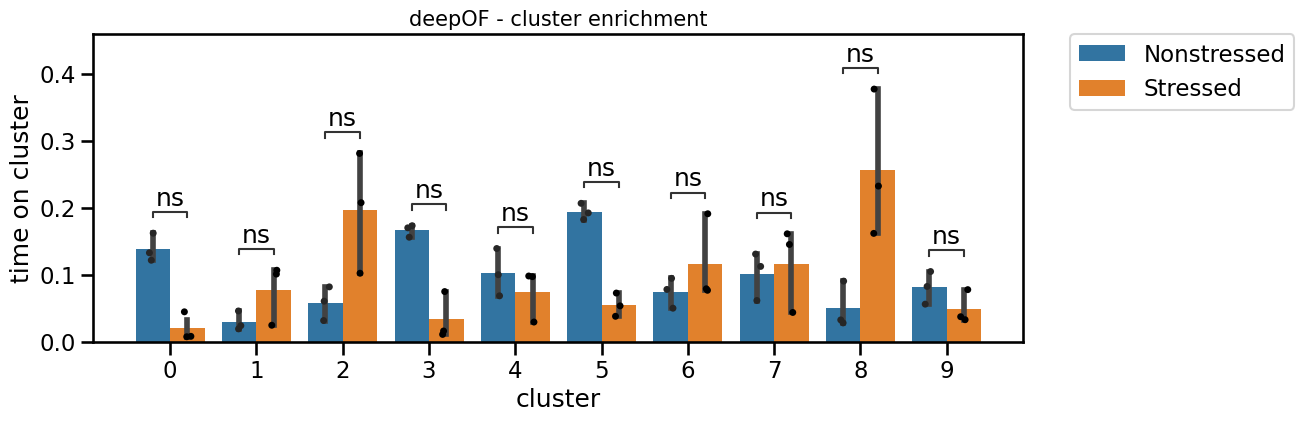

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

deepof.visuals.plot_cluster_enrichment(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    normalize=True,
    bin_size=126,
    bin_index=0,
    add_stats="Mann-Whitney",
    exp_condition="CSDS",
    verbose=False,
    ax=ax,
)

In [40]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    cluster_assignments=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=150,
    selected_cluster=2,
    dpi=60,
    center="arena",    
)

html = display.HTML(video)
display.display(html)
plt.close()

In [41]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    cluster_assignments=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=150,
    selected_cluster=8,
    
    dpi=60,
    center="arena",
)

html = display.HTML(video)
display.display(html)
plt.close()

### Exploring cluster dynamics across conditions

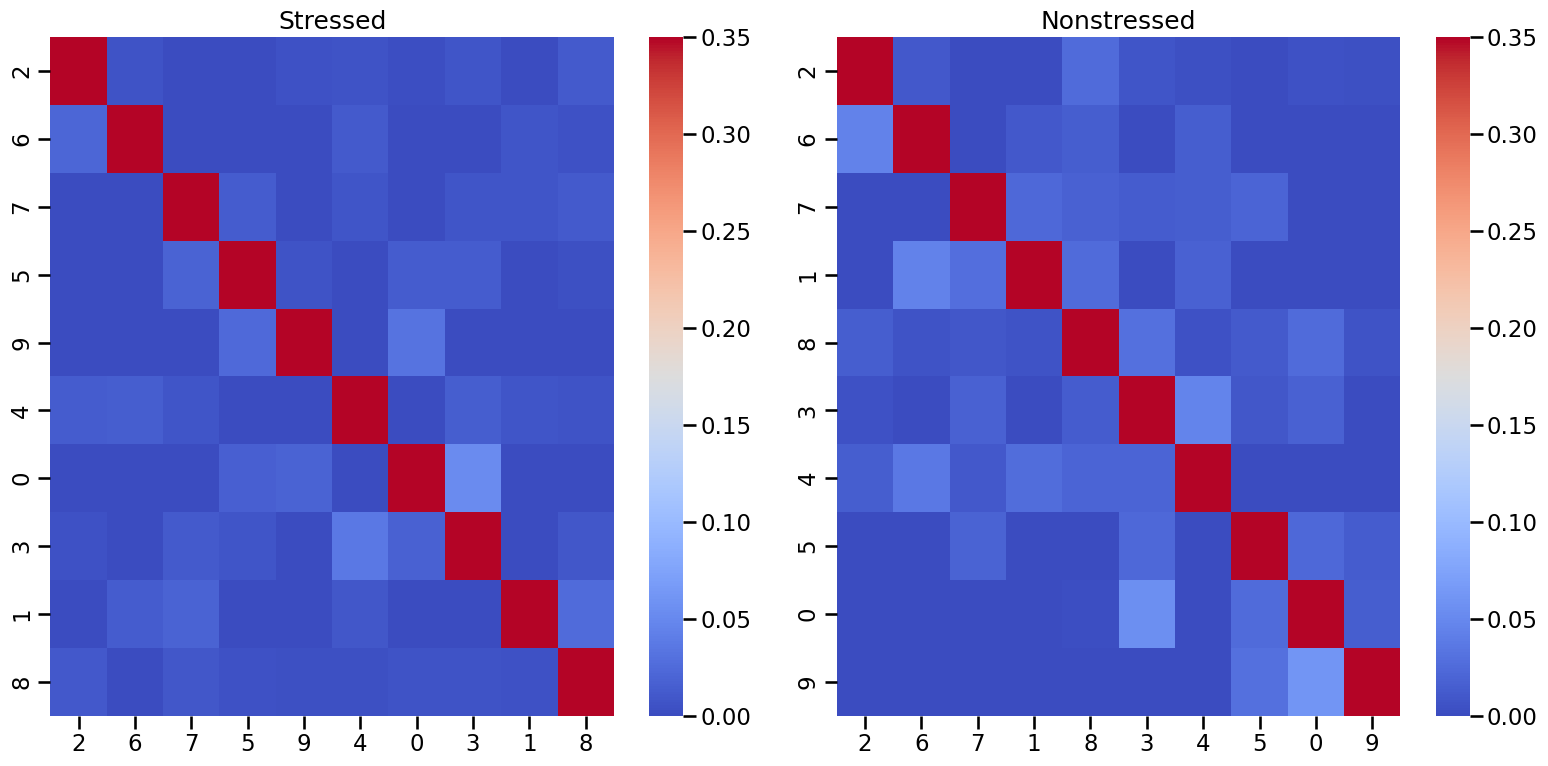

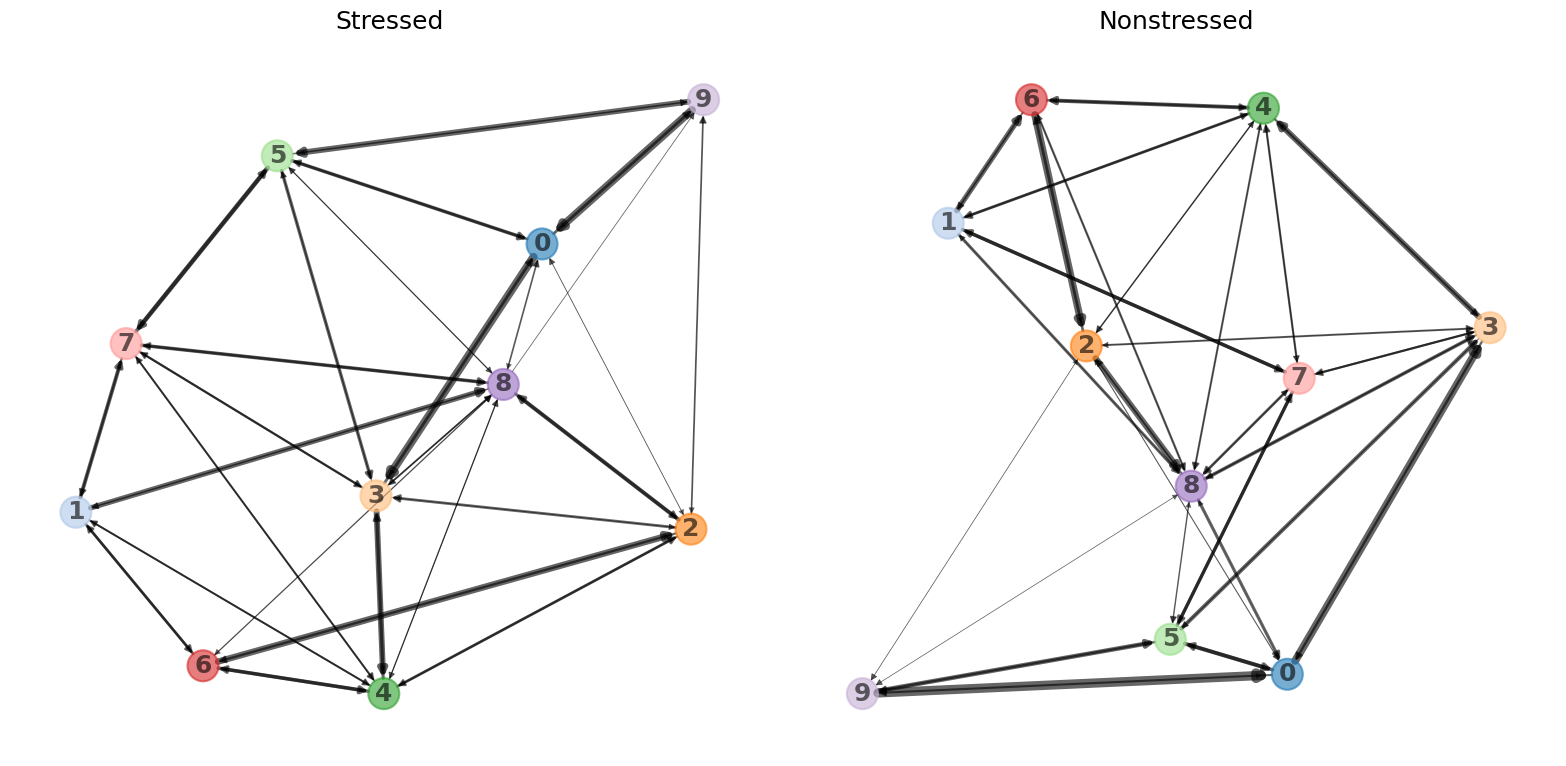

In [31]:
# Transition matrices and heatmaps
deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
   # cluster=False,
    visualization="heatmaps",
    exp_condition="CSDS",
)

deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
    visualization="networks",
    silence_diagonal=True,
    exp_condition="CSDS",
)

# TODO:

# Add option to use umap location on network plots

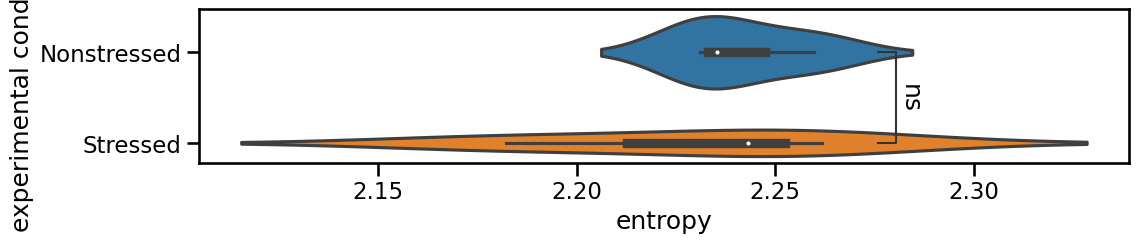

In [32]:
# Entropy plots
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

deepof.visuals.plot_stationary_entropy(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    exp_condition="CSDS",
    ax=ax,
)

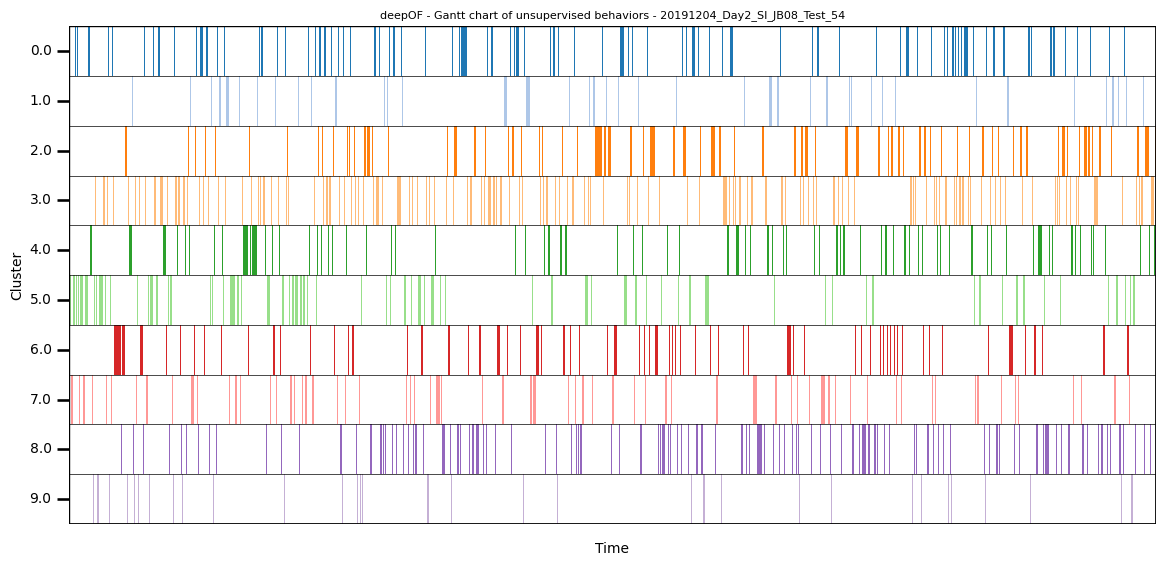

In [36]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_gantt( # TODO: Add X axis in seconds, and parameter to overlay events as vertical black bars!
    my_deepof_project, # TODO: restrict time span! it looks noisy
    soft_counts=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
)

### Combining supervised and unsupervised information

#### Visualize global embeddings using the retrieved traits.

#### Visualize animated unsupervised embeddings, coloured by specific traits.

### Interpreting clusters using SHAP

In [ ]:
%%time
csds_chunk_stats, hard_counts, sampled_breaks = deepof.post_hoc.annotate_time_chunks(
    deepof_project=my_deepof_project,
    soft_counts=soft_counts,
    breaks=breaks,
    #supervised_annotations=csds_OF_supervised_annotations,
    kin_derivative=1,
    window_size=13,
    include_distances=True,
    min_confidence=0.9,
    include_angles=True,
    include_areas=True,
    aggregate="mean",
    samples=1500,
)

In [ ]:
%%time
full_cluster_clf, cluster_gbm_performance, groups = deepof.post_hoc.train_supervised_cluster_detectors(
    csds_chunk_stats, hard_counts, sampled_breaks, n_folds=5, verbose=2,
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("notebook")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="confusion_matrix",
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("talk")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="balanced_accuracy",
    save=False,
)

In [ ]:
shap_values, explainer, data_to_explain = deepof.post_hoc.explain_clusters(
    csds_chunk_stats, hard_counts, full_cluster_clf, samples=100
)

In [ ]:
from matplotlib import colors as plt_colors
from ipywidgets import interact
import copy
import numpy as np

# Plot swarm plots per cluster
@interact()
def plot_shap_swarm_per_cluster(
    cluster=["all"] + list(range(10)), save=False,
):
    
    deepof.visuals.plot_shap_swarm_per_cluster(
        my_deepof_project, 
        data_to_explain, 
        shap_values, cluster, 
        save=save,
        show=False,
    )
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

### Exporting cluster video snippets

In [45]:
deepof.visuals.export_annotated_video( # TODO: add exp condition filters to output names
    my_deepof_project,
    soft_counts,
    breaks,
    frame_limit_per_video=100,
)

In [46]:
pwd

'/Users/lucas_miranda/PycharmProjects/deepof'